# Introduction to Machine Learning 
## with Landslide Data and Scikit-learn


<img src= "https://github.com/waterhackweek/waterhackweek.github.io/blob/master/assets/images/waterhackweek2020logo-words.JPG?raw=true"
style="float:left;width:175px;padding:10px">   


<br />


This version of the ML tutorial runs on CyberGIS for Water JupyterHub and moves the data from HydroShare.

**First run,  fix_cjw_landlab_env.ipynb to set up environment.**

[Download Waterhackweek Live unedited tutorial recorded 9/2/2020 [MP4]](https://www.hydroshare.org/resource/c59689b403b3484182b016fbcd0267ac/data/contents/wednesdayLectures2020/2020.9._Andreas.mp4)

Work in Progress!  This is one component of an experiment to design reproducible multiple model workflows for Adaptation Infrastructure research using climate change, disaster, and geohealth datasets. Vision: Launch field-future workflows from the [Geoweaver for Watermesh](https://www.hydroshare.org/resource/40b3fbf0057644fab59d463b8c6311c5/) web app with customizable authentication to improve web access to earth data using [Geoweaver](https://esipfed.github.io/Geoweaver/). 

Under construction!   Check out and use our Citation Wrangling Notebook [Open-Interoperability-References](https://js-168-155.jetstream-cloud.org/user/christinabandaragoda/lab/tree/Github/water_hackweek_2020_machine_learning/notebooks/Open-Interoperability-References.ipynb) Under construction!


# 1.0 Import Software Tools and Update References

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
import os
import dabl

# 2.0 Cloud Transport Data

Ask friends for help when using research cyberinfrastructure.

### Scott can you help debug this? 

### This is how Drew has his example for CyberGIS for Water

In [4]:
resource_id = 'c83e2ac0cee34496980857830ed4ffdb'
import json
import os
from hs_restclient import HydroShare, HydroShareAuthOAuth2
oauth = json.loads(os.environ["HS_AUTH"])
auth = HydroShareAuthOAuth2(oauth[1], "", token=oauth[0])
hs = HydroShare(auth=auth)
base_dir = os.path.abspath('/home/jovyan/work')
download_dir = os.path.join(base_dir, 'Downloads')
!mkdir -p {download_dir}
hs.getResource(resource_id, destination=download_dir, unzip=True)

### I only want to move over one file, but this syntax makes everything unhappy.

#### I asked #help-desk and Scott let me know in waterhackweek.slack.com that I was using the wrong function.  

You want to GET a file from HydroShare at the beginning of the Notebook. 

You want to ADD a file to HydroShare at the end of the Notebook. 

In [37]:
hs.getResourceFile(resource_id, 'Logistic_PCA/ROC_data.csv')

<generator object Response.iter_content.<locals>.generate at 0x7fb57be1ba50>

In [43]:
print('This is where the Notebook is putting outputs:')
!pwd
print('This is where the HydroShare function puts the data moved to the JupyterHub server from the HydroShare storage:')
download_dir

This is where the Notebook is putting outputs:
/home/jovyan/work/Github/water_hackweek_2020_machine_learning/notebooks
This is where the HydroShare function puts the data moved to the JupyterHub server from the HydroShare storage:


'/home/jovyan/work/Downloads'

# 3.0 Import and Format Data in an Interactive Python Environment

In [44]:
!pwd

/home/jovyan/work/Github/water_hackweek_2020_machine_learning/notebooks


In [46]:
hydroshare_resource_folder = download_dir + '/c83e2ac0cee34496980857830ed4ffdb/c83e2ac0cee34496980857830ed4ffdb/data/contents'
data_folder = hydroshare_resource_folder +'/Logistic_PCA/'
print('This HydroShare resource has been downloaded to: %s' % data_folder)

This HydroShare resource has been downloaded to: /home/jovyan/work/Downloads/c83e2ac0cee34496980857830ed4ffdb/c83e2ac0cee34496980857830ed4ffdb/data/contents/Logistic_PCA/


In [48]:
ROC_data_file = os.path.join(data_folder, 'ROC_data.csv')

In [47]:
data_raw = pd.read_csv(ROC_data_file, index_col=0)
data_raw.head()

/opt/conda/envs/landlab/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,LS_type,DA_area,prob_inh,prob_dyn,slope_tan,elevation,curvature,aspect,wet_index,litho,lulc
3970,8.0,3.0,0.0156,0.000,0.951556,2180.698,4.515543,80.28688,3.450854,5.0,71.0
3971,8.0,3.0,0.0124,0.000,1.093501,2166.145,3.625163,52.44894,3.311813,5.0,71.0
3972,8.0,3.0,0.0222,0.000,0.690770,2140.360,-1.464627,40.48208,4.597811,5.0,71.0
3973,8.0,3.0,0.0304,0.596,0.407125,2127.395,-1.632731,29.35348,5.113264,5.0,31.0
3975,8.0,3.0,0.0222,0.000,0.349647,2114.717,0.455268,51.53106,4.885499,5.0,52.0


In [49]:
data = data_raw.copy()
LS_type_mapping = {8: "No landslides", 1: "Fall/Topple", 2: "Torrent",   3: "Avalanche", 4: "Slump/Creep", 5: "Sackung"}
DA_area_mapping = {1: "runout", 2: "source", 3: "other"}
lithology_mapping = {1: 'Unconsolidated Sediment', 2: 'Ultrabasic rock', 3: 'Weak Metamorphic Foliated',
                     4: 'Sedimentary Rock', 5: 'Hard Metamorphic', 6: 'Intrusive Igneous',
                     7: 'Volcanic/Extrusive Igneous'}
LULC_mapping = {71: "Herbaceous", 52: "Shrubland", 41: "Forest", 31: "Barren",  21: "Developed"}

data['LS_type'] = data_raw.LS_type.map(LS_type_mapping)
data['DA_area'] = data_raw.DA_area.map(DA_area_mapping)
data['litho'] = data_raw.litho.map(lithology_mapping)
data['lulc'] = data_raw.lulc.map(LULC_mapping)

# 4.0 Investigate the Data for Machine Learning Applications


In [10]:
continuous = data.dtypes == float
continuous

LS_type      False
DA_area      False
prob_inh      True
prob_dyn      True
slope_tan     True
elevation     True
curvature     True
aspect        True
wet_index     True
litho        False
lulc         False
dtype: bool

#### 4.1 Experiment 1 = Reducing count of useless 'No Landslides' data and train on landslide type

In [11]:
data.LS_type.value_counts()

No landslides    2333568
Avalanche          44094
Fall/Topple        30908
Torrent             1721
Slump/Creep          248
Sackung               13
Name: LS_type, dtype: int64

#### 4.2 Experiment 2 = Use only 'source area' observations in field sampling and train on lithology

In [12]:
data.litho.value_counts()

Hard Metamorphic              1140394
Intrusive Igneous              591754
Weak Metamorphic Foliated      395836
Unconsolidated Sediment        182407
Volcanic/Extrusive Igneous      53935
Sedimentary Rock                45815
Ultrabasic rock                   411
Name: litho, dtype: int64

# 5.0 Experiment with various dimensions of physical properties

### 5.1. Experiment 1: Does the size of 'no landslide' data sampling bias the prediction? 
Subset by throwing out a pile of data to shrink data size. We don't care about 'no landslide' samples for predicting types of landslides anyway.

In [13]:
# make sure none of the groups have more than 80,000 samples
# This is a bit of a silly way to subsample the "no landslide" class to make the dataset more managable
data_smallsample = data.groupby('LS_type').apply(lambda x: pd.DataFrame.sample(x, min(80000, len(x)))).reset_index(drop=True)

In [14]:
data_smallsample.LS_type.value_counts()

No landslides    80000
Avalanche        44094
Fall/Topple      30908
Torrent           1721
Slump/Creep        248
Sackung             13
Name: LS_type, dtype: int64

### 5.2. Experiment 2: Is source area initiation of landslides predicted by lithology?
Selecting landslide samples that include the source area uphill; this is important for the initiation of shallow landslides

In [50]:
data_sourcesample= data[data['DA_area'] == 'source']

### Make sure you know the size, shape and meaning of the datasets. You are a scientist!

In [51]:
print('Full dataset shape = (rows, columns) = {X}'.format(X = data.shape))
print('Smaller dataset with reduced "no landslide" samples = (rows, columns) = {X}'.format(X = data_smallsample.shape))
print('Smallest dataset of source area mapped locations = (rows, columns) = {X}'.format(X = data_sourcesample.shape))

Full dataset shape = (rows, columns) = (2410552, 11)
Smaller dataset with reduced "no landslide" samples = (rows, columns) = (156984, 11)
Smallest dataset of source area mapped locations = (rows, columns) = (1144, 11)


# 6.0 Inspect the data from new perspectives. [Thank you Andreas Mueller!](https://amueller.github.io/dabl/dev/) 

### 6.1 What is the distribution of data by landslide type? 

Target looks like classification


/opt/conda/envs/landlab/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 170 outliers in column prob_inh.
  int(dropped), series.name), UserWarning)
/opt/conda/envs/landlab/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 11 outliers in column wet_index.
  int(dropped), series.name), UserWarning)
/opt/conda/envs/landlab/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 194 outliers in column slope_tan.
  int(dropped), series.name), UserWarning)
/opt/conda/envs/landlab/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 247 outliers in column curvature.
  int(dropped), series.name), UserWarning)


Linear Discriminant Analysis training set score: 0.248


/opt/conda/envs/landlab/lib/python3.7/site-packages/dabl/plot/utils.py:364: UserWarning: FixedFormatter should only be used together with FixedLocator
  for t in ax.get_xticklabels()]
/opt/conda/envs/landlab/lib/python3.7/site-packages/dabl/plot/utils.py:364: UserWarning: FixedFormatter should only be used together with FixedLocator
  for t in ax.get_xticklabels()]
/opt/conda/envs/landlab/lib/python3.7/site-packages/dabl/plot/utils.py:364: UserWarning: FixedFormatter should only be used together with FixedLocator
  for t in ax.get_xticklabels()]


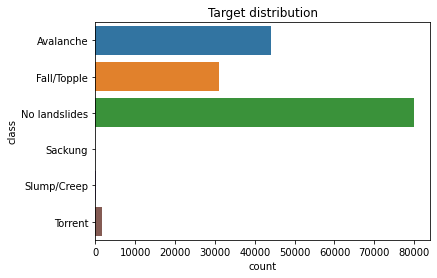

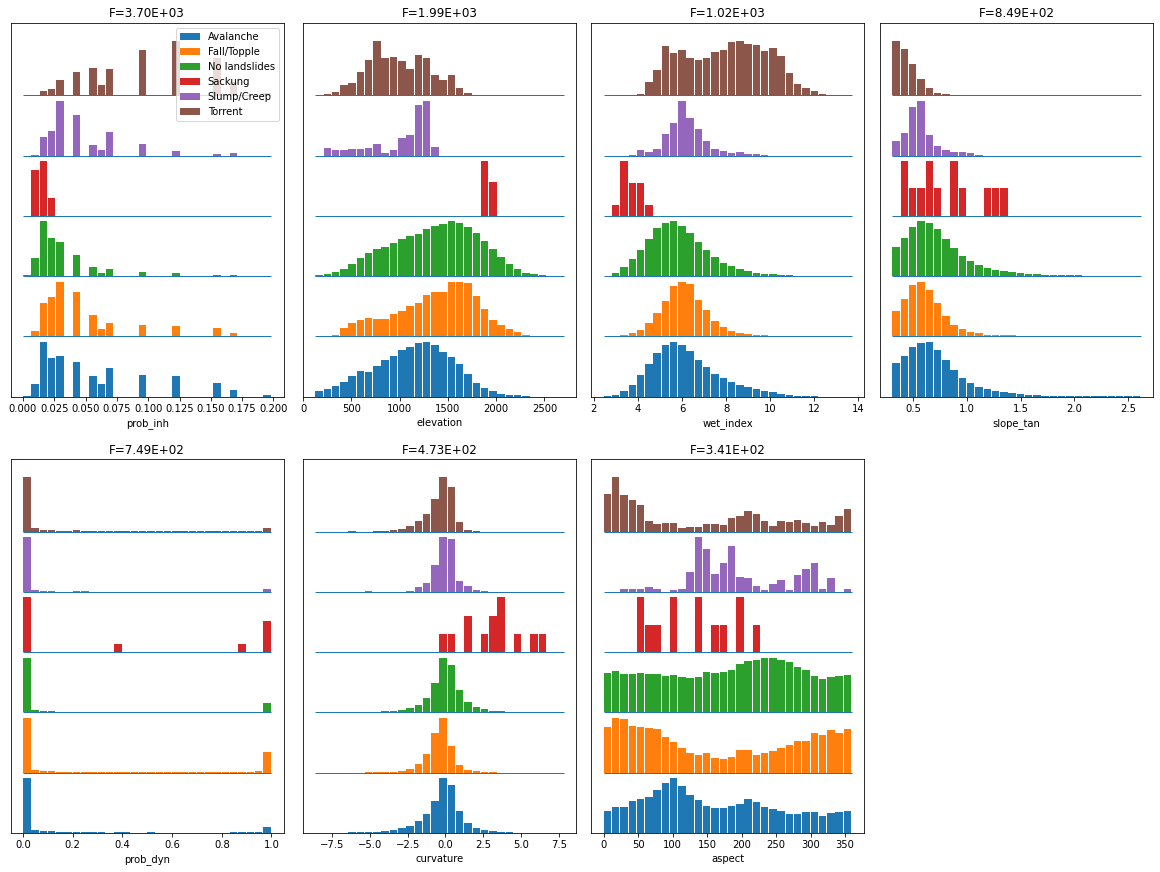

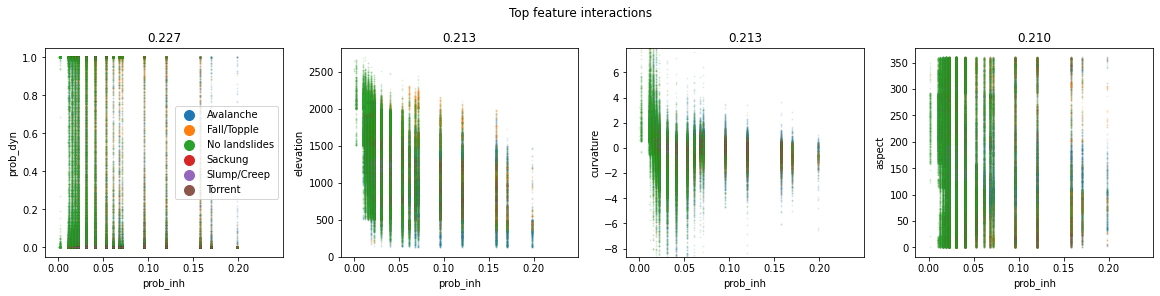

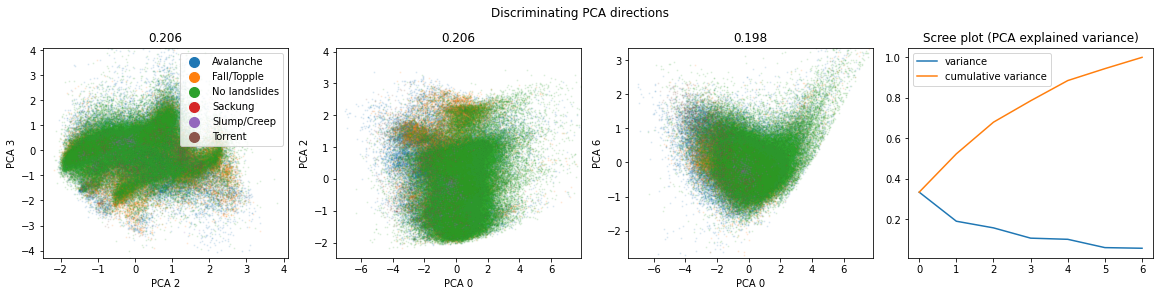

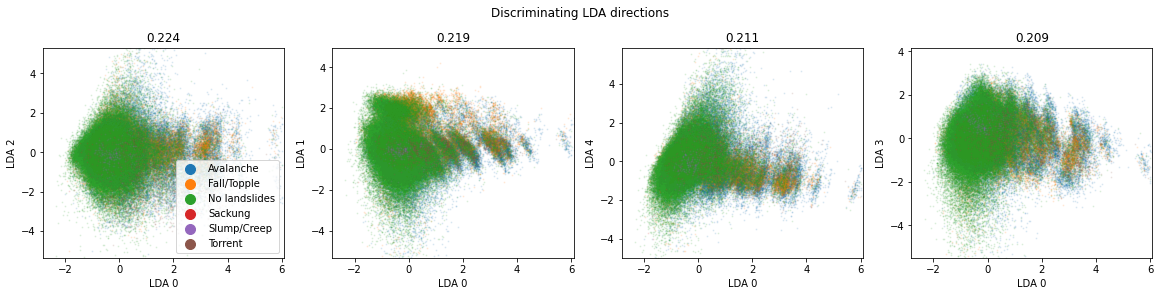

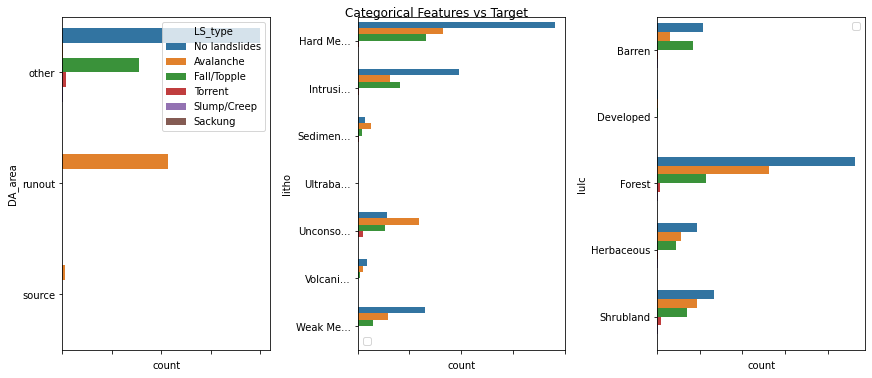

In [52]:
dabl.plot(data_smallsample, target_col='LS_type')

### 6.2 What is the distribution of data by lithology looking only at geographic source areas of landslides? 

/opt/conda/envs/landlab/lib/python3.7/site-packages/dabl/preprocessing.py:318: UserWarning: Discarding near-constant features: ['LS_type', 'DA_area']
  near_constant.index[near_constant].tolist()))


Target looks like classification


/opt/conda/envs/landlab/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 2 outliers in column prob_inh.
  int(dropped), series.name), UserWarning)
/opt/conda/envs/landlab/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 2 outliers in column curvature.
  int(dropped), series.name), UserWarning)


Linear Discriminant Analysis training set score: 0.507


/opt/conda/envs/landlab/lib/python3.7/site-packages/dabl/plot/utils.py:364: UserWarning: FixedFormatter should only be used together with FixedLocator
  for t in ax.get_xticklabels()]


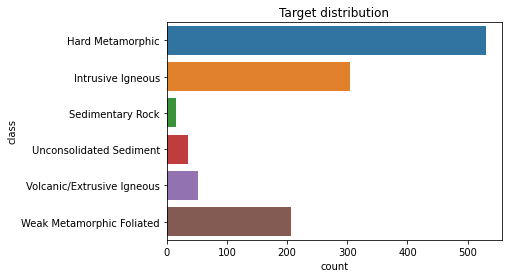

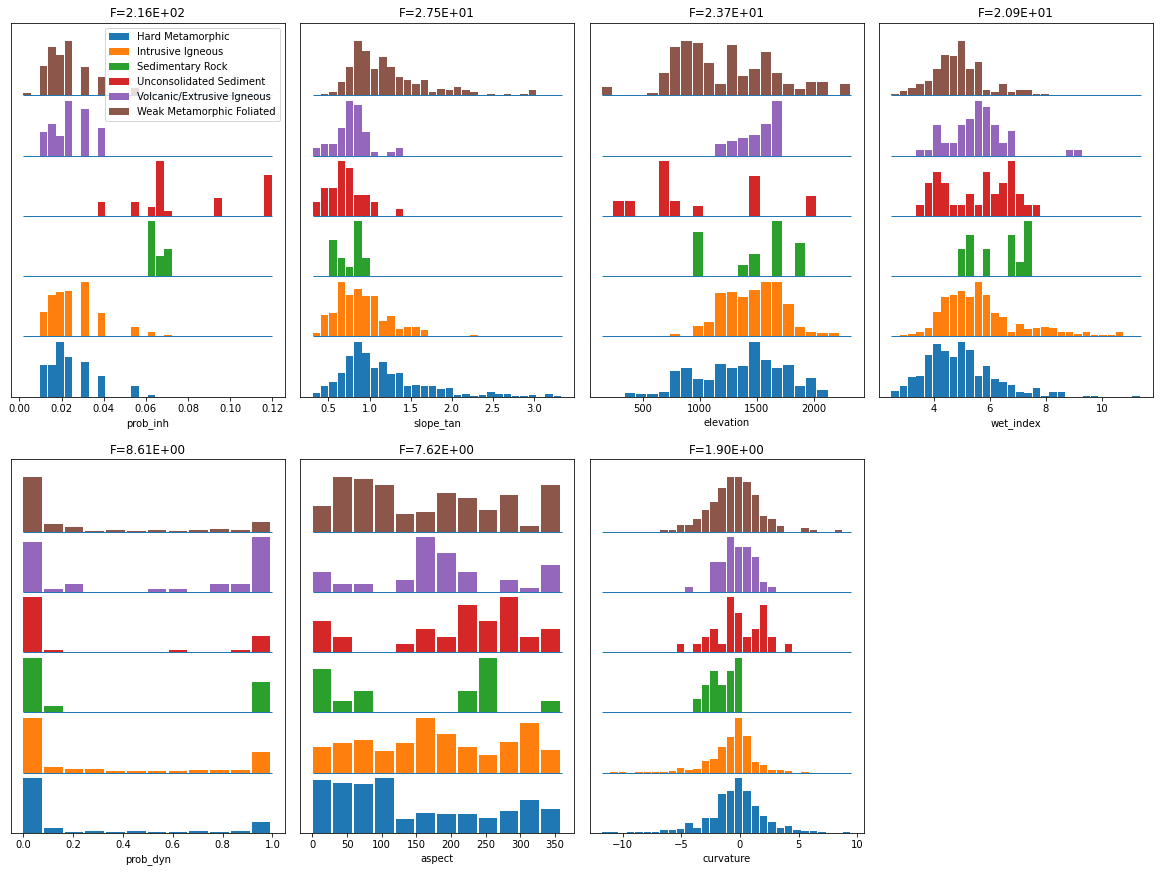

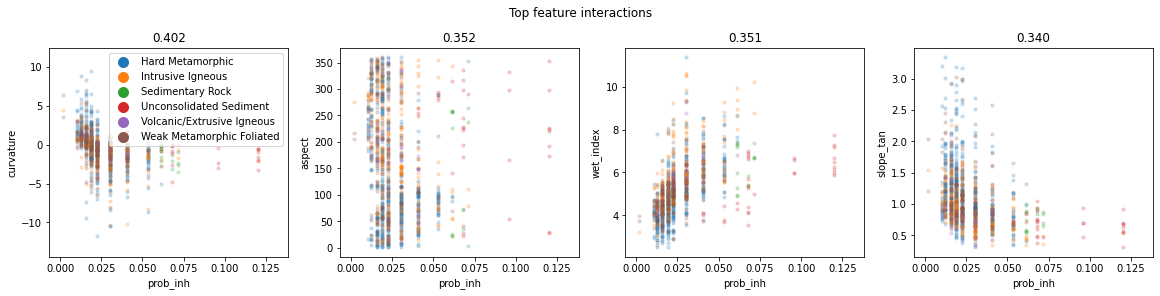

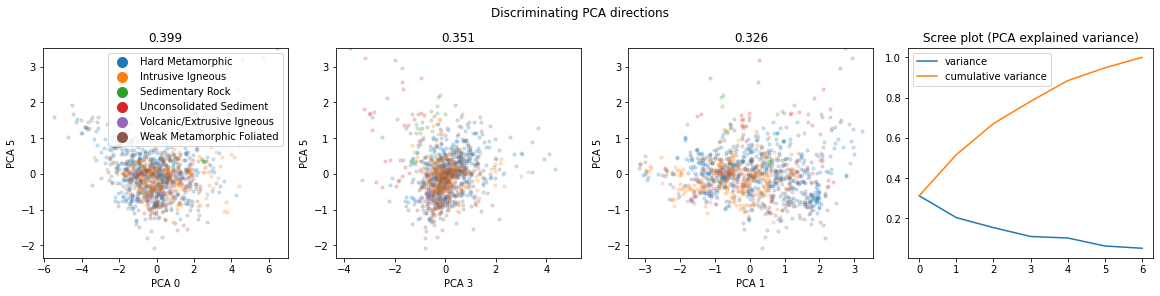

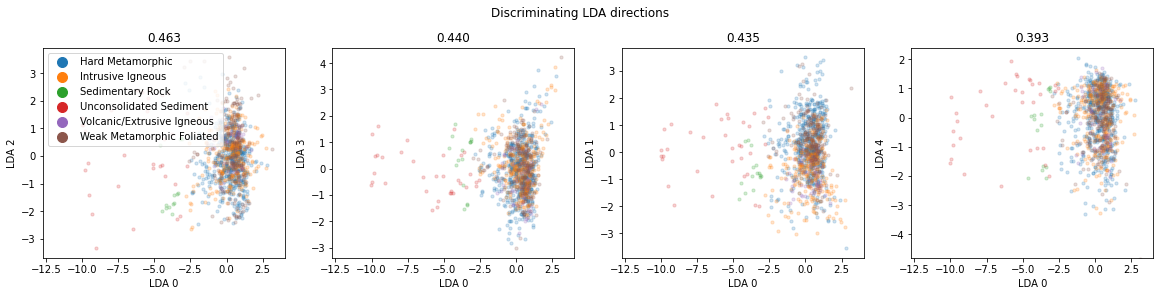

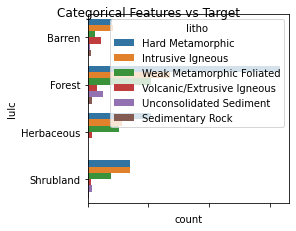

In [18]:
dabl.plot(data_sourcesample, target_col='litho')

# 7.0 Let the computer work. Machine learning.

## 7.1 Choose Landslide Type or Lithology 
Training Data used in ML

In [66]:
landslidetype = 'no'



In [67]:
if landslidetype == 'yes':
    X = data_smallsample.drop('LS_type', axis=1)
    y = data_smallsample['LS_type']
    print('Using sample for landslide type')
    
else :
        X = data_sourcesample.drop('litho', axis=1)
        y = data_sourcesample['litho']
        print('Using sample for source area and lithology')
    

Using sample for source area and lithology


In [68]:
X_dummy = pd.get_dummies(X)
X_dummy.head()

,prob_inh,prob_dyn,slope_tan,elevation,curvature,aspect,wet_index,LS_type_Avalanche,DA_area_source,lulc_Barren,lulc_Forest,lulc_Herbaceous,lulc_Shrubland
1092196,0.0404,0.000,0.629953,1422.430,-1.708659,166.9855,6.970096,1,1,0,0,0,1
1092197,0.0156,0.416,0.898552,1423.579,1.167955,171.0869,4.615778,1,1,0,0,1,0
1092198,0.0190,0.448,0.898977,1415.968,-0.082831,162.6679,4.956755,1,1,0,0,1,0
1094381,0.0190,0.232,0.807357,1446.651,-0.179443,182.0399,5.096666,1,1,0,0,1,0
1094382,0.0190,0.332,0.857790,1448.161,0.465807,175.5728,4.742892,1,1,0,0,1,0


In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dummy, y, random_state=0)

In [70]:
X_train.shape

(858, 13)

In [71]:
y_train.value_counts()

Hard Metamorphic              407
Intrusive Igneous             220
Weak Metamorphic Foliated     159
Volcanic/Extrusive Igneous     36
Unconsolidated Sediment        25
Sedimentary Rock               11
Name: litho, dtype: int64

In [72]:
pd.Series(y_train).value_counts(normalize=True)

Hard Metamorphic              0.474359
Intrusive Igneous             0.256410
Weak Metamorphic Foliated     0.185315
Volcanic/Extrusive Igneous    0.041958
Unconsolidated Sediment       0.029138
Sedimentary Rock              0.012821
Name: litho, dtype: float64

### 7.1.1 Logistic regression 

0) Import your model class - we did this in the Section 1.0.

1) Instantiate an object and set the parameters

In [73]:
logreg = LogisticRegression(max_iter=1000)

2) Fit the model

In [74]:
logreg.fit(X_train, y_train)

/opt/conda/envs/landlab/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(max_iter=1000)

3) Apply / evaluate

In [75]:
print(logreg.predict(X_train[:10]))

['Hard Metamorphic' 'Hard Metamorphic' 'Weak Metamorphic Foliated'
 'Intrusive Igneous' 'Hard Metamorphic' 'Intrusive Igneous'
 'Hard Metamorphic' 'Intrusive Igneous' 'Weak Metamorphic Foliated'
 'Hard Metamorphic']


In [76]:
logreg.score(X_train, y_train)

0.5104895104895105

In [77]:
logreg.score(X_test, y_test)

0.46853146853146854

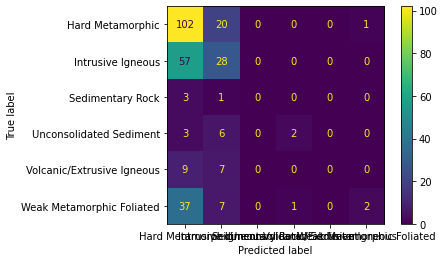

In [78]:
plot_confusion_matrix(logreg, X_test, y_test)

### 7.1.2 Random Forest Classifier

In [79]:
from sklearn.ensemble import RandomForestClassifier

In [80]:
rf = RandomForestClassifier()

In [81]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [82]:
rf.score(X_train, y_train)

1.0

In [83]:
rf.score(X_test, y_test)

0.7202797202797203

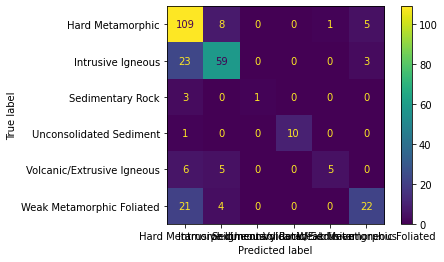

In [84]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf, X_test, y_test)

# To Do  - save space delimited files